In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import cv2
from time import time

import tensorflow as tf
tf.reset_default_graph()
# tf.enable_eager_execution()
tf.VERSION

'1.13.1'

### Load Data

('Train data : ', 40000, 40000, 9, 0)
(['../data/cifar10/23681_8.jpg', '../data/cifar10/49252_4.jpg', '../data/cifar10/38347_1.jpg'], [8, 4, 1])


('Validation data : ', 10000, 10000, 9, 0)
(['../data/cifar10/12385_9.jpg', '../data/cifar10/20257_0.jpg', '../data/cifar10/37042_8.jpg'], [9, 0, 8])


(32, 32, 3)


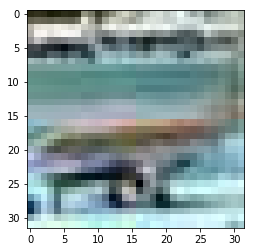

In [2]:
import numpy as np

src_dir = '../data/cifar10/'
img_paths = glob(src_dir + '*.jpg')
N = len(img_paths)

idx = np.arange(N)
np.random.shuffle(idx)
num_train = int(0.8*N)
train_paths = [img_paths[idx[i]] for i in range(num_train)]
val_paths = [img_paths[idx[num_train + i]] for i in range(N - num_train)]

train_labels = []
for path in train_paths:
    name = os.path.basename(path)
    train_labels.append(int(name[name.find('_')+1:-4]))
print('Train data : ', len(train_paths), len(train_labels), max(train_labels), min(train_labels))
print(train_paths[:3], train_labels[:3])
print('\n')


val_labels = []
for path in val_paths:
    name = os.path.basename(path)
    val_labels.append(int(name[name.find('_')+1:-4]))
print('Validation data : ', len(val_paths), len(val_labels), max(val_labels), min(val_labels))
print(val_paths[:3], val_labels[:3])
print('\n')

# Display an image
img = cv2.imread(val_paths[1])
print(img.shape)
plt.imshow(img)
plt.show()

### Model 

In [3]:
import tensorflow.keras as K
import tensorflow.keras.layers as layers

def conv2d_block(x, filters, kernel_size = (3,3), \
        padding='same', activation = 'relu', \
        batchnorm=True, pool = True, dropout = 0.25):
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, \
            padding=padding, activation=activation)(x)
    x = layers.BatchNormalization()(x) if batchnorm else x
    x = layers.MaxPool2D(2, 2)(x) if pool else x
    x = layers.Dropout(rate = dropout)(x)
    return x

def fc_block(x, units, activation = 'relu', dropout=0.25):
    x = layers.Dense(units, activation)(x)
    x = layers.Dropout(rate = dropout)(x)
    return x

def smallCNN(x, num_classes=10):
    x = conv2d_block(x, 32, pool=False, dropout=0)
    x = conv2d_block(x, 32, pool=True, dropout=0.25)
    x = conv2d_block(x, 64, pool=False, dropout=0)
    x = conv2d_block(x, 64, pool=True, dropout=0.25)
    x = layers.Flatten()(x)
    x = fc_block(x, 512, dropout=0.5)
    x = fc_block(x, num_classes, 'softmax')
    return x

### Create Estimator from the model

In [10]:
def get_loss(name):
    if name == 'categorical_crossentropy':
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = y, logits = y_pred)
        loss = tf.reduce_mean(loss)
    return loss

x = tf.keras.Input(shape=(32, 32, 3))
y_pred = smallCNN(x)
loss = tf.keras.losses.categorical_crossentropy
# loss = lambda y, y_pred: get_loss('categorical_crossentropy', y, y_pred)
optimizer = tf.train.AdamOptimizer()
model = tf.keras.Model(inputs=x, outputs=y_pred)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
estimator = tf.keras.estimator.model_to_estimator(model, model_dir = 'est_model2', \
                                                config=tf.estimator.RunConfig(save_summary_steps=2,\
                                                                             log_step_count_steps=1))

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe65eeb1f50>, '_model_dir': 'est_model2', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 2, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 1, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


### Create datagen for estimator

In [5]:
# Preprocess data
def preprocess_data(path, label):
    img = tf.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize_images(img, [32, 32])
    img = img/255.0
    label = tf.one_hot(label, 10)
    return img, label

# Augment data (translate and rotate)
def augment_data(img, label):
    img_tx = tf.contrib.image.rotate(img, \
            angles = tf.random_uniform(shape=[], minval=-10, maxval=10))
    img_tx = tf.contrib.image.translate(img_tx, \
            translations = [tf.random_uniform(shape=[], minval=-10, maxval=10), \
                           tf.random_uniform(shape=[], minval=-10, maxval=10)])
    return img_tx, label

def input_fn(img_paths, labels, epochs, batch_size, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(len(img_paths))
    dataset = dataset.map(preprocess_data)
    if augment:
        dataset = dataset.map(augment_data)
    dataset = dataset.repeat(epochs).batch(batch_size)
    dataset = dataset.prefetch(None)
    return dataset

### SessionRun hooks: Time History Hook

In [6]:
import time

class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

### Train the estimator

In [11]:
BATCH_SIZE = 32
EPOCHS = 2

train_paths = train_paths[:1000]
train_labels = train_labels[:1000]
train_input = lambda: input_fn(train_paths, train_labels,
                              epochs=EPOCHS, batch_size=BATCH_SIZE,
                              shuffle=True, augment=True)
hook_time = TimeHistory()
estimator.train(input_fn = train_input, hooks = [hook_time])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='est_model2/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('est_model2/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: batch_normalization_v1_5/beta; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: batch_normalization_v1_4/gamma; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: batch_normalization_v1_7/beta; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: batch_normalization_v1_4/beta; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: batch_normalization_v1_5/gamma; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: conv2d_4/kernel; prev_var_name: Unch

INFO:tensorflow:Saving checkpoints for 63 into est_model2/model.ckpt.
INFO:tensorflow:Loss for final step: 5.72144.


In [8]:
print(len(hook_time.times))

63


In [9]:
estimator.evaluate(lambda:input_fn(val_paths,
                                   val_labels,
                                   epochs=1,
                                   batch_size=64))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Starting evaluation at 2019-03-24T06:51:34Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from est_model1/model.ckpt-63
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-24-06:52:03
INFO:tensorflow:Saving dict for global step 63: categorical_accuracy = 0.0989, global_step = 63, loss = 4.09097
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 63: est_model1/model.ckpt-63


{'categorical_accuracy': 0.098899998, 'global_step': 63, 'loss': 4.090971}